# Predicting the Success of NBA Draftees Based on College Performance
***
## Introduction

I want to build a model to predict the 5-year peak performance of NCAA basketball players drafted by the NBA, measured by their maximum single-season Win Shares (an advanced statistic that assigns credit for team success to individuals on the team). The majority of an NBA player's development takes place during this 5-year time frame. Statistics from a player's final NCAA season along with biographical information will be used as input for the model. Accurate performance prediction of NBA prospects is highly valued by the ownership and management of NBA teams. It helps them effectively determine which players to acquire and significantly impacts team success, which often relates directly to the organization's financial success. 

The necessary dataset will be created by gathering NCAA and NBA player statistics from www.sports-reference.com with the use of sportsreference, a third-party open-source API, and BeautifulSoup. Only players drafted by the NBA from 2011-2015 will be included in the dataset, since several NCAA advanced statistics (i.e. Box Plus Minus) are unavailable for prior seasons. I will use repeated stratified nested cross-validation for model assessment, due to the limited size of the dataset. Several different statistical and supervised machine learning techniques will be used, coupled with Pearson's rank based variable selection, to model the data. As an evaluation metric, I have chosen to use mean squared error.

## Dataset Creation

All necessary packages are imported, and display options and plotting styles are set.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from datetime import datetime, timedelta
from urllib.request import urlopen
from bs4 import BeautifulSoup
from scipy.stats import ks_2samp
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.base import clone
import ast
from sportsreference.ncaab.roster import Player as Player_ncaa
from sportsreference.nba.roster import Player as Player_nba
from sportsreference.ncaab.teams import Teams

In [3]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)
pd.options.display.multi_sparse = False

In [4]:
sns.set(style='darkgrid')

In [5]:
blues = sns.color_palette('Blues_r')

### [Skip ahead to Exploratory Data Analysis.](#eda)

<br>
The sportsreference API pulls statistics from the relevant websites of www.sports-reference.com: www.sports-reference.com/cbb (NCAA stats) and www.basketball-reference.com (NBA stats). sportsreference.ncaab.teams.Teams (imported as Teams) retreives NCAA team statistics, while sportsreference.ncaab.roster.Player (imported as Player_ncaa) and sportsreference.nba.roster.Player (imported as Player_nba) retreive NCAA and NBA player statistics respectively.

Using the sportsreference API, a dictionary is created with multiple statistics for each NCAA basketball team from 2011 - 2015. The dictionary is then converted into the DataFrame, team_df.

In [5]:
team_dict = {'year': [], 'team': [], 'pace': [], 'srs': [], 'sos': []}

for year in range(2011, 2016):
    for team in Teams(year): 
        pace = team.pace
        srs = team.simple_rating_system
        sos = team.strength_of_schedule
        
        team_dict['year'].append(year)
        team_dict['team'].append(team.abbreviation)
        team_dict['pace'].append(pace)
        team_dict['srs'].append(srs)
        team_dict['sos'].append(sos)

In [6]:
team_df = pd.DataFrame(team_dict)
team_df.set_index(['year', 'team'], drop=True, inplace=True)
team_df.head()

,,pace,srs,sos
year,team,,,
2011,AIR-FORCE,62.5,2.71,3.31
2011,AKRON,67.0,2.15,-1.02
2011,ALABAMA-AM,71.6,-15.19,-11.75
2011,ALABAMA-BIRMINGHAM,63.1,8.55,2.78
2011,ALABAMA-STATE,66.5,-13.37,-10.31


The following function calculates the age of an NCAA player on the date of the NBA draft using the sportsreference API.

In [7]:
def get_player_age(nba_id, draft_year):
    birth_date = Player_nba(nba_id).birth_date
    datetimeFormat = '%Y-%m-%d'
    draft_date = str(draft_year) + '-06-20'
    diff = datetime.strptime(draft_date, datetimeFormat) - birth_date
    days = diff.days
    return round(days/365, 2)

This function uses BeautifulSoup to return the RSCI (Recruiting Services Consensus Index) Ranking of an NCAA player from www.sports-reference.com. 

The RSCI ranks the top 100 high school players each year. I have decided to give unranked players an RSCI ranking of 101.

In [8]:
def get_rsci_rank(ncaa_id):
    url = 'https://www.sports-reference.com/cbb/players/{}.html'.format(ncaa_id)
    html = urlopen(url)
    soup = BeautifulSoup(html)
    element = soup.find('strong', text='RSCI Top 100:')
    
    # Change the RSCI rank of unranked players to 101
    if element == None:
        return 101
    
    rsci_text = element.parent.text
    
    def extract_rsci_rank(str):
        slice = str[14:]
        space_idx = slice.index(' ')
        return int(slice[:space_idx])
    
    return extract_rsci_rank(rsci_text)

The source_data.csv file contains both the www.sports-reference.com NCAA ID and NBA ID of each player so that both their NCAA and NBA statistics can be retrieved. The file also includes other information such as ESPN pre-draft ranking and projected NBA position. The player height and weight data is taken from the NBA Draft Combine.

source_data.csv is converted into a DataFrame and then a list of dictionaries, source_dict_list.

In [9]:
source_df = pd.read_csv('source_data.csv')
source_dict_list = source_df.to_dict('records')
source_df.head()

,player,ncaa_id,nba_id,draft_year,draft_pick,college,years_nba,espn_pre_draft_rank,projected_pos_nba,height,weight,team_games_2020
0,Kyrie Irving,kyrie-irving-1,irvinky01,2011,1,Duke,9,1,Guard,73.75,191,0
1,Derrick Williams,derrick-williams-2,willide02,2011,2,Arizona,7,2,Wing,79.25,248,0
2,Tristan Thompson,tristan-thompson-2,thomptr01,2011,4,Texas,9,6,Big,79.50,227,0
3,Brandon Knight,brandon-knight-1,knighbr03,2011,8,Kentucky,8,5,Guard,73.50,177,0
4,Kemba Walker,kemba-walker-1,walkeke02,2011,9,UConn,9,9,Guard,71.50,184,0


For each dictionary (representing a player) in source_dict_list, a DataFrame is created containing biographical information and NCAA statistics from the player's final college season, with the use of the sportsreference API, team_df, get_player_age(), and get_rsci_rank().

A list is formed of all the player DataFrames, and then the DataFrames are all concatenated into one DataFrame, ncaa_df.

In [10]:
%%time
ncaa_list = []

for index in source_dict_list:
    player = index['player']
    ncaa_id = index['ncaa_id']
    nba_id = index['nba_id']
    draft_pick = index['draft_pick']
    draft_year = index['draft_year']
    pre_draft_rank = index['espn_pre_draft_rank']
    position_nba = index['projected_pos_nba']
    height = index['height']
    weight = index['weight']
    
    # Return a DataFrame of all of the player's college stats
    player_df = Player_ncaa(ncaa_id).dataframe
    
    # Remove the career total row of the DataFrame and return only the row of the last season
    player_df = player_df.drop(('Career',)).tail(1)
    
    # Assign the player's NBA ID to the player_id column for merging later
    player_df.player_id = nba_id
    
    # Reset the index, moving the original index of seasons to a column named 'season_ncaa'
    player_df = player_df.reset_index().rename(columns={'level_0': 'season_ncaa'})
    
    # Make new columns
    player_df['player'] = player
    player_df['draft_pick'] = draft_pick
    player_df['pre_draft_rank'] = pre_draft_rank
    player_df['position_nba'] = position_nba
    player_df['rsci_rank'] = get_rsci_rank(ncaa_id)
    player_df['age'] = get_player_age(nba_id, draft_year)
    
    # Get value of the player's college team abbreviation in uppercase
    team_ncaa = player_df.loc[0, 'team_abbreviation'].upper()
    
    # Change values to those from source file
    player_df['height'] = height
    player_df['weight'] = weight
    
    # Make new columns of stats from the player's college team
    player_df['pace'] = team_df.loc[(draft_year, team_ncaa), 'pace']
    player_df['sos'] = team_df.loc[(draft_year, team_ncaa), 'sos']
    player_df['srs'] = team_df.loc[(draft_year, team_ncaa), 'srs']
    
    # Append the player's DataFrame to ncaa_list
    ncaa_list.append(player_df)

# Create ncaa_df DataFrame from all the player DataFrames in ncaa_list
ncaa_df = pd.concat(ncaa_list)

# Reset the index of ncaa_df
ncaa_df.reset_index(drop=True, inplace=True)

# Slice ncaa_df so that it only includes the necessary columns
ncaa_df = ncaa_df.loc[:, ['player_id', 'player', 'season_ncaa', 'draft_pick', 'pre_draft_rank', 'rsci_rank', 'position_nba',
    'age', 'height', 'weight', 'assist_percentage', 'block_percentage', 'box_plus_minus', 'defensive_box_plus_minus', 
    'defensive_rebound_percentage', 'defensive_win_shares', 'effective_field_goal_percentage', 'field_goal_attempts', 
    'field_goal_percentage', 'field_goals', 'free_throw_attempt_rate', 'free_throw_percentage', 'games_played', 'games_started',
    'minutes_played', 'offensive_box_plus_minus', 'offensive_rebound_percentage', 'offensive_win_shares', 'personal_fouls', 
    'player_efficiency_rating', 'points', 'points_produced', 'steal_percentage', 'three_point_attempt_rate', 
    'three_point_percentage', 'total_rebound_percentage', 'true_shooting_percentage', 'turnover_percentage', 
    'two_point_percentage', 'usage_percentage', 'win_shares', 'win_shares_per_40_minutes', 'pace', 'sos', 'srs']]

ncaa_df.head()

CPU times: user 6min 16s, sys: 7.7 s, total: 6min 24s
Wall time: 8min 2s


,player_id,player,season_ncaa,draft_pick,pre_draft_rank,rsci_rank,position_nba,age,height,weight,assist_percentage,block_percentage,box_plus_minus,defensive_box_plus_minus,defensive_rebound_percentage,defensive_win_shares,effective_field_goal_percentage,field_goal_attempts,field_goal_percentage,field_goals,free_throw_attempt_rate,free_throw_percentage,games_played,games_started,minutes_played,offensive_box_plus_minus,offensive_rebound_percentage,offensive_win_shares,personal_fouls,player_efficiency_rating,points,points_produced,steal_percentage,three_point_attempt_rate,three_point_percentage,total_rebound_percentage,true_shooting_percentage,turnover_percentage,two_point_percentage,usage_percentage,win_shares,win_shares_per_40_minutes,pace,sos,srs
0,irvinky01,Kyrie Irving,2010-11,1,1,2,Guard,19.25,73.75,191,29.8,1.8,14.8,5.0,10.6,0.6,0.615,104,0.529,55,0.683,0.901,11,8,303,9.8,2.3,1.8,23,32.5,192,189.0,3.0,0.375,0.462,6.7,0.697,16.4,0.569,26.4,2.4,0.320,70.2,8.32,24.51
1,willide02,Derrick Williams,2010-11,2,2,100,Wing,20.08,79.25,248,8.7,2.3,12.1,2.5,21.9,1.9,0.650,380,0.595,226,0.871,0.746,38,38,1141,9.6,11.8,6.0,106,32.8,741,675.0,1.9,0.195,0.568,17.0,0.690,15.7,0.601,28.9,7.9,0.279,66.9,7.99,16.54
2,thomptr01,Tristan Thompson,2010-11,4,6,9,Big,20.28,79.50,227,8.1,7.2,8.9,4.5,13.7,2.7,0.546,315,0.546,172,0.829,0.487,36,34,1104,4.4,14.0,2.8,100,24.2,471,475.0,1.8,0.000,None,13.8,0.536,12.7,0.546,22.4,5.5,0.200,67.8,7.96,20.82
3,knighbr03,Brandon Knight,2010-11,8,5,4,Guard,19.56,73.50,177,23.4,0.6,5.5,0.9,10.2,1.8,0.508,513,0.423,217,0.333,0.795,38,38,1363,4.5,2.2,3.6,83,19.3,657,652.0,1.1,0.450,0.377,6.3,0.553,16.8,0.461,27.0,5.3,0.157,66.2,8.91,20.30
4,walkeke02,Kemba Walker,2010-11,9,9,15,Guard,21.13,71.50,184,28.0,0.5,13.1,3.9,11.5,2.4,0.478,739,0.428,316,0.426,0.819,41,41,1543,9.2,3.9,7.3,56,29.9,965,930.0,3.1,0.307,0.33,7.9,0.543,9.5,0.471,32.4,9.7,0.251,65.1,10.44,17.95


New columns, such as minutes_per_game, are added to ncaa_df consisting of statistics derived from several other columns.

In [11]:
ncaa_df['minutes_per_game'] = round(ncaa_df.minutes_played / ncaa_df.games_played, 1)
ncaa_df['offensive_ws_per_40_minutes'] = round(ncaa_df.offensive_win_shares * 40 / ncaa_df.minutes_played, 3)
ncaa_df['defensive_ws_per_40_minutes'] = round(ncaa_df.defensive_win_shares * 40 / ncaa_df.minutes_played, 3)
ncaa_df['fouls_per_40_minutes'] = round(ncaa_df.personal_fouls * 40 / ncaa_df.minutes_played, 1)
ncaa_df['pts_per_100_poss'] = \
    round((ncaa_df.points * 40 * 100) / (ncaa_df.pace * ncaa_df.minutes_played), 1)
ncaa_df['fga_per_100_poss'] = \
    round((ncaa_df.field_goal_attempts * 40 * 100) / (ncaa_df.pace * ncaa_df.minutes_played), 1)
ncaa_df['pts_produced_per_100_poss'] = \
    round((ncaa_df.points_produced * 40 * 100) / (ncaa_df.pace * ncaa_df.minutes_played), 1)

ncaa_df.head()

,player_id,player,season_ncaa,draft_pick,pre_draft_rank,rsci_rank,position_nba,age,height,weight,assist_percentage,block_percentage,box_plus_minus,defensive_box_plus_minus,defensive_rebound_percentage,defensive_win_shares,effective_field_goal_percentage,field_goal_attempts,field_goal_percentage,field_goals,free_throw_attempt_rate,free_throw_percentage,games_played,games_started,minutes_played,offensive_box_plus_minus,offensive_rebound_percentage,offensive_win_shares,personal_fouls,player_efficiency_rating,points,points_produced,steal_percentage,three_point_attempt_rate,three_point_percentage,total_rebound_percentage,true_shooting_percentage,turnover_percentage,two_point_percentage,usage_percentage,win_shares,win_shares_per_40_minutes,pace,sos,srs,minutes_per_game,offensive_ws_per_40_minutes,defensive_ws_per_40_minutes,fouls_per_40_minutes,pts_per_100_poss,fga_per_100_poss,pts_produced_per_100_poss
0,irvinky01,Kyrie Irving,2010-11,1,1,2,Guard,19.25,73.75,191,29.8,1.8,14.8,5.0,10.6,0.6,0.615,104,0.529,55,0.683,0.901,11,8,303,9.8,2.3,1.8,23,32.5,192,189.0,3.0,0.375,0.462,6.7,0.697,16.4,0.569,26.4,2.4,0.320,70.2,8.32,24.51,27.5,0.238,0.079,3.0,36.1,19.6,35.5
1,willide02,Derrick Williams,2010-11,2,2,100,Wing,20.08,79.25,248,8.7,2.3,12.1,2.5,21.9,1.9,0.650,380,0.595,226,0.871,0.746,38,38,1141,9.6,11.8,6.0,106,32.8,741,675.0,1.9,0.195,0.568,17.0,0.690,15.7,0.601,28.9,7.9,0.279,66.9,7.99,16.54,30.0,0.210,0.067,3.7,38.8,19.9,35.4
2,thomptr01,Tristan Thompson,2010-11,4,6,9,Big,20.28,79.50,227,8.1,7.2,8.9,4.5,13.7,2.7,0.546,315,0.546,172,0.829,0.487,36,34,1104,4.4,14.0,2.8,100,24.2,471,475.0,1.8,0.000,None,13.8,0.536,12.7,0.546,22.4,5.5,0.200,67.8,7.96,20.82,30.7,0.101,0.098,3.6,25.2,16.8,25.4
3,knighbr03,Brandon Knight,2010-11,8,5,4,Guard,19.56,73.50,177,23.4,0.6,5.5,0.9,10.2,1.8,0.508,513,0.423,217,0.333,0.795,38,38,1363,4.5,2.2,3.6,83,19.3,657,652.0,1.1,0.450,0.377,6.3,0.553,16.8,0.461,27.0,5.3,0.157,66.2,8.91,20.30,35.9,0.106,0.053,2.4,29.1,22.7,28.9
4,walkeke02,Kemba Walker,2010-11,9,9,15,Guard,21.13,71.50,184,28.0,0.5,13.1,3.9,11.5,2.4,0.478,739,0.428,316,0.426,0.819,41,41,1543,9.2,3.9,7.3,56,29.9,965,930.0,3.1,0.307,0.33,7.9,0.543,9.5,0.471,32.4,9.7,0.251,65.1,10.44,17.95,37.6,0.189,0.062,1.5,38.4,29.4,37.0


This function removes any rows (seasons) from an NBA player's DataFrame that occur more than 5 years after their draft year.

In [12]:
def only_5_years_after_draft(df, draft_year):
    for i in range(len(df), 0, -1):   
        last_index = df.index[-1][0]
        last_year = int('20' + last_index[-2:])
        if last_year - draft_year > 5:
            df = df.drop(df.index[-1])
    return df

When the sportsreference API is used to get the NBA statistics of a drafted player who never plays in the NBA, an empty DataFrame is returned. If I then create a DataFrame for the player, and I want to concatenate it with DataFrames of other NBA players, it must have the same list of columns.

columns_nba contains the columns of the DataFrame returned for an NBA player by the sportsreference API.

In [13]:
columns_nba = ['season_nba', 'and_ones', 'assist_percentage', 'assists', 'block_percentage','blocking_fouls', 'blocks',
    'box_plus_minus', 'center_percentage', 'defensive_box_plus_minus', 'defensive_rebound_percentage', 'defensive_rebounds', 
    'defensive_win_shares', 'dunks', 'effective_field_goal_percentage', 'field_goal_attempts',
    'field_goal_perc_sixteen_foot_plus_two_pointers', 'field_goal_perc_ten_to_sixteen_feet', 
    'field_goal_perc_three_to_ten_feet', 'field_goal_perc_zero_to_three_feet', 'field_goal_percentage', 'field_goals', 
    'free_throw_attempt_rate', 'free_throw_attempts', 'free_throw_percentage', 'free_throws', 'games_played', 'games_started',
    'half_court_heaves', 'half_court_heaves_made', 'height', 'lost_ball_turnovers', 'minutes_played', 'nationality',
    'net_plus_minus', 'offensive_box_plus_minus', 'offensive_fouls', 'offensive_rebound_percentage', 'offensive_rebounds',
    'offensive_win_shares', 'on_court_plus_minus', 'other_turnovers', 'passing_turnovers', 'percentage_field_goals_as_dunks',
    'percentage_of_three_pointers_from_corner', 'percentage_shots_three_pointers', 'percentage_shots_two_pointers',
    'percentage_sixteen_foot_plus_two_pointers', 'percentage_ten_to_sixteen_footers', 'percentage_three_to_ten_footers',
    'percentage_zero_to_three_footers', 'personal_fouls', 'player_efficiency_rating', 'player_id', 'point_guard_percentage',
    'points', 'points_generated_by_assists', 'position', 'power_forward_percentage', 'salary', 'shooting_distance',
    'shooting_fouls', 'shooting_fouls_drawn', 'shooting_guard_percentage', 'shots_blocked', 'small_forward_percentage', 
    'steal_percentage', 'steals', 'take_fouls', 'team_abbreviation', 'three_point_attempt_rate', 'three_point_attempts', 
    'three_point_percentage', 'three_point_shot_percentage_from_corner', 'three_pointers', 'three_pointers_assisted_percentage',
    'total_rebound_percentage', 'total_rebounds', 'true_shooting_percentage', 'turnover_percentage', 'turnovers', 
    'two_point_attempts', 'two_point_percentage', 'two_pointers', 'two_pointers_assisted_percentage', 'usage_percentage', 
    'value_over_replacement_player', 'weight', 'win_shares', 'win_shares_per_48_minutes']

Now I will create the DataFrame, nba_df, which contains every player's relevant NBA statistics.

In [14]:
%%time
nba_list = []

for index in source_dict_list:
    nba_id = index['nba_id']
    draft_year = index['draft_year']
    team_games_2020 = index['team_games_2020']
    
    # DataFrame of all of the player's NBA stats
    player_df = Player_nba(nba_id).dataframe
    
    # If a player did not play in the NBA, an empty DataFrame is returned
    if player_df.empty:
        # Create a 1 row DataFrame for player with 0 values for all columns
        data = [tuple(0 for i in range(90))]
        player_df = pd.DataFrame.from_records(data, columns=columns_nba)
        
        # Assign the player's NBA ID to the player_id column for merging later
        player_df.player_id = nba_id
    else:
        # Get the index number of the row with index ('Career',)
        idx = player_df.index.get_loc(('Career',))
        
        # Select all rows of the DataFrame before the career total row, then select only the first 5 rows of that slice
        player_df = player_df.iloc[:idx,:].head(5)
        
        # Select only the rows(seasons) that occurred at most 5 years after the player was drafted
        player_df = only_5_years_after_draft(player_df, draft_year)
        
        # Reset the index, moving the original index of seasons to a column named 'season_nba'
        player_df = player_df.reset_index().rename(columns={'level_0': 'season_nba'})
    
    # Create column for team games in 2020
    player_df['team_games_2020'] = team_games_2020
    
    # Append the player's DataFrame to nba_list
    nba_list.append(player_df)

# Create nba_df DataFrame from all the player DataFrames in nba_list
nba_df = pd.concat(nba_list)

# Reset the index of nba_df
nba_df.reset_index(drop=True, inplace=True)

# Slice nba_df so that it only includes the necessary columns
nba_df = nba_df.loc[:,['player_id', 'season_nba', 'win_shares', 'team_games_2020']]

# Rename columns
nba_df.columns = ['player_id', 'season_nba', 'win_shares_nba', 'team_games_2020']

# Replace None values with 0
nba_df.fillna(0, inplace=True)

nba_df.head()

CPU times: user 4min 53s, sys: 4.91 s, total: 4min 58s
Wall time: 5min 45s


,player_id,season_nba,win_shares_nba,team_games_2020
0,irvinky01,2011-12,4.1,0
1,irvinky01,2012-13,5.3,0
2,irvinky01,2013-14,6.7,0
3,irvinky01,2014-15,10.4,0
4,irvinky01,2015-16,5.0,0


Now nba_df and ncaa_df are merged together.

In [15]:
df = pd.merge(ncaa_df, nba_df, on='player_id')

df.head()

,player_id,player,season_ncaa,draft_pick,pre_draft_rank,rsci_rank,position_nba,age,height,weight,assist_percentage,block_percentage,box_plus_minus,defensive_box_plus_minus,defensive_rebound_percentage,defensive_win_shares,effective_field_goal_percentage,field_goal_attempts,field_goal_percentage,field_goals,free_throw_attempt_rate,free_throw_percentage,games_played,games_started,minutes_played,offensive_box_plus_minus,offensive_rebound_percentage,offensive_win_shares,personal_fouls,player_efficiency_rating,points,points_produced,steal_percentage,three_point_attempt_rate,three_point_percentage,total_rebound_percentage,true_shooting_percentage,turnover_percentage,two_point_percentage,usage_percentage,win_shares,win_shares_per_40_minutes,pace,sos,srs,minutes_per_game,offensive_ws_per_40_minutes,defensive_ws_per_40_minutes,fouls_per_40_minutes,pts_per_100_poss,fga_per_100_poss,pts_produced_per_100_poss,season_nba,win_shares_nba,team_games_2020
0,irvinky01,Kyrie Irving,2010-11,1,1,2,Guard,19.25,73.75,191,29.8,1.8,14.8,5.0,10.6,0.6,0.615,104,0.529,55,0.683,0.901,11,8,303,9.8,2.3,1.8,23,32.5,192,189.0,3.0,0.375,0.462,6.7,0.697,16.4,0.569,26.4,2.4,0.32,70.2,8.32,24.51,27.5,0.238,0.079,3.0,36.1,19.6,35.5,2011-12,4.1,0
1,irvinky01,Kyrie Irving,2010-11,1,1,2,Guard,19.25,73.75,191,29.8,1.8,14.8,5.0,10.6,0.6,0.615,104,0.529,55,0.683,0.901,11,8,303,9.8,2.3,1.8,23,32.5,192,189.0,3.0,0.375,0.462,6.7,0.697,16.4,0.569,26.4,2.4,0.32,70.2,8.32,24.51,27.5,0.238,0.079,3.0,36.1,19.6,35.5,2012-13,5.3,0
2,irvinky01,Kyrie Irving,2010-11,1,1,2,Guard,19.25,73.75,191,29.8,1.8,14.8,5.0,10.6,0.6,0.615,104,0.529,55,0.683,0.901,11,8,303,9.8,2.3,1.8,23,32.5,192,189.0,3.0,0.375,0.462,6.7,0.697,16.4,0.569,26.4,2.4,0.32,70.2,8.32,24.51,27.5,0.238,0.079,3.0,36.1,19.6,35.5,2013-14,6.7,0
3,irvinky01,Kyrie Irving,2010-11,1,1,2,Guard,19.25,73.75,191,29.8,1.8,14.8,5.0,10.6,0.6,0.615,104,0.529,55,0.683,0.901,11,8,303,9.8,2.3,1.8,23,32.5,192,189.0,3.0,0.375,0.462,6.7,0.697,16.4,0.569,26.4,2.4,0.32,70.2,8.32,24.51,27.5,0.238,0.079,3.0,36.1,19.6,35.5,2014-15,10.4,0
4,irvinky01,Kyrie Irving,2010-11,1,1,2,Guard,19.25,73.75,191,29.8,1.8,14.8,5.0,10.6,0.6,0.615,104,0.529,55,0.683,0.901,11,8,303,9.8,2.3,1.8,23,32.5,192,189.0,3.0,0.375,0.462,6.7,0.697,16.4,0.569,26.4,2.4,0.32,70.2,8.32,24.51,27.5,0.238,0.079,3.0,36.1,19.6,35.5,2015-16,5.0,0


If a player has negative win shares for an NBA season, the amount is converted to zero. This is necessary so that drafted NBA players who never play in the NBA (0 win shares) are not considered more valuable than NBA players with negative win shares.

For the shortened seasons in 2012 and 2020, I prorate win shares to 82 games.

In [16]:
df.win_shares_nba = df.win_shares_nba.apply(lambda x: 0 if x < 0 else x)

# The 2011-2012 NBA season was shortened to 66 games
# Prorate all win shares for the the 2011-2012 NBA season to 82 games
df.win_shares_nba = \
    df.apply(lambda x: round(82/66 * x.win_shares_nba, 1) if x.season_nba == '2011-12' else x.win_shares_nba, axis=1)

# Many of the 2015 draftees played on 2020 NBA teams that played less than 82 games 
# Prorate the 2020 win shares for those players to 82 games
df.win_shares_nba = \
    df.apply(lambda x: round((82/x.team_games_2020) * x.win_shares_nba, 1) \
        if (x.team_games_2020 > 0 and x.season_nba == '2019-20') else x.win_shares_nba, axis=1)

I now change the DataFrame so that each player has one row containing the statistics from both their final college season and their maximum win share NBA season.

In [17]:
index = df.groupby(['player_id'])['win_shares_nba'].transform(max) == df['win_shares_nba']

df = df[index].drop_duplicates('player_id')

df.reset_index(drop=True, inplace=True)

df.head()

,player_id,player,season_ncaa,draft_pick,pre_draft_rank,rsci_rank,position_nba,age,height,weight,assist_percentage,block_percentage,box_plus_minus,defensive_box_plus_minus,defensive_rebound_percentage,defensive_win_shares,effective_field_goal_percentage,field_goal_attempts,field_goal_percentage,field_goals,free_throw_attempt_rate,free_throw_percentage,games_played,games_started,minutes_played,offensive_box_plus_minus,offensive_rebound_percentage,offensive_win_shares,personal_fouls,player_efficiency_rating,points,points_produced,steal_percentage,three_point_attempt_rate,three_point_percentage,total_rebound_percentage,true_shooting_percentage,turnover_percentage,two_point_percentage,usage_percentage,win_shares,win_shares_per_40_minutes,pace,sos,srs,minutes_per_game,offensive_ws_per_40_minutes,defensive_ws_per_40_minutes,fouls_per_40_minutes,pts_per_100_poss,fga_per_100_poss,pts_produced_per_100_poss,season_nba,win_shares_nba,team_games_2020
0,irvinky01,Kyrie Irving,2010-11,1,1,2,Guard,19.25,73.75,191,29.8,1.8,14.8,5.0,10.6,0.6,0.615,104,0.529,55,0.683,0.901,11,8,303,9.8,2.3,1.8,23,32.5,192,189.0,3.0,0.375,0.462,6.7,0.697,16.4,0.569,26.4,2.4,0.320,70.2,8.32,24.51,27.5,0.238,0.079,3.0,36.1,19.6,35.5,2014-15,10.4,0
1,willide02,Derrick Williams,2010-11,2,2,100,Wing,20.08,79.25,248,8.7,2.3,12.1,2.5,21.9,1.9,0.650,380,0.595,226,0.871,0.746,38,38,1141,9.6,11.8,6.0,106,32.8,741,675.0,1.9,0.195,0.568,17.0,0.690,15.7,0.601,28.9,7.9,0.279,66.9,7.99,16.54,30.0,0.210,0.067,3.7,38.8,19.9,35.4,2015-16,3.6,0
2,thomptr01,Tristan Thompson,2010-11,4,6,9,Big,20.28,79.50,227,8.1,7.2,8.9,4.5,13.7,2.7,0.546,315,0.546,172,0.829,0.487,36,34,1104,4.4,14.0,2.8,100,24.2,471,475.0,1.8,0.000,None,13.8,0.536,12.7,0.546,22.4,5.5,0.200,67.8,7.96,20.82,30.7,0.101,0.098,3.6,25.2,16.8,25.4,2015-16,8.7,0
3,knighbr03,Brandon Knight,2010-11,8,5,4,Guard,19.56,73.50,177,23.4,0.6,5.5,0.9,10.2,1.8,0.508,513,0.423,217,0.333,0.795,38,38,1363,4.5,2.2,3.6,83,19.3,657,652.0,1.1,0.450,0.377,6.3,0.553,16.8,0.461,27.0,5.3,0.157,66.2,8.91,20.30,35.9,0.106,0.053,2.4,29.1,22.7,28.9,2014-15,4.5,0
4,walkeke02,Kemba Walker,2010-11,9,9,15,Guard,21.13,71.50,184,28.0,0.5,13.1,3.9,11.5,2.4,0.478,739,0.428,316,0.426,0.819,41,41,1543,9.2,3.9,7.3,56,29.9,965,930.0,3.1,0.307,0.33,7.9,0.543,9.5,0.471,32.4,9.7,0.251,65.1,10.44,17.95,37.6,0.189,0.062,1.5,38.4,29.4,37.0,2015-16,9.9,0


Several unnecessary columns are removed. 

In [18]:
df.drop(columns=['player_id','season_ncaa','season_nba','team_games_2020'], inplace=True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 51 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   player                           235 non-null    object 
 1   draft_pick                       235 non-null    int64  
 2   pre_draft_rank                   235 non-null    int64  
 3   rsci_rank                        235 non-null    int64  
 4   position_nba                     235 non-null    object 
 5   age                              235 non-null    float64
 6   height                           235 non-null    float64
 7   weight                           235 non-null    int64  
 8   assist_percentage                235 non-null    float64
 9   block_percentage                 235 non-null    float64
 10  box_plus_minus                   235 non-null    float64
 11  defensive_box_plus_minus         235 non-null    float64
 12  defensive_rebound_perc

three_point_percentage is the only column with null values.

The null values are replaced with zeros.

In [20]:
df.three_point_percentage.fillna(0, inplace=True)

Now I confirm that the remaining 'object' columns do not contain multiple data types.

In [21]:
{col: set(map(type, df[col])) for col in df.select_dtypes(include=[object])}

{'player': {str}, 'position_nba': {str}}

Upon inspection, I found very few errors in the dataset.

Only 2 players, Andre Drummond and Jarnell Stokes, need their RSCI rankings corrected.

In [22]:
df.loc[df['player'] == 'Andre Drummond', 'rsci_rank'] = 2
df.loc[df['player'] == 'Jarnell Stokes', 'rsci_rank'] = 14

The data types of several columns are now converted to 'int64'.

In [23]:
convert_dict = {
    'field_goal_attempts': 'int64', 'field_goals': 'int64', 'games_played': 'int64', 'games_started': 'int64', 
    'minutes_played': 'int64', 'personal_fouls': 'int64', 'points': 'int64', 'points_produced': 'int64'
}
  
df = df.astype(convert_dict)

Before finalizing the dataset, I will remove redundant features in order to reduce multicollinearity as well as model complexity. Multicollinearity is problematic because it makes it difficult to determine the individual effects of features.

The redundant features consist of both linear combinations and nonlinear functions of other features. The former possess perfect multicollinearity, violating the assumptions of ordinary least squares regression.

In [24]:
# Linear combinations of features
lc_features = ['offensive_box_plus_minus', 'offensive_win_shares', 'defensive_rebound_percentage', 
               'offensive_ws_per_40_minutes']

# Nonlinear functions of features
nf_features = ['field_goal_attempts', 'win_shares', 'defensive_win_shares', 'field_goals', 'personal_fouls', 'points', 
               'points_produced', 'minutes_played', 'field_goal_percentage', 'effective_field_goal_percentage',
               'true_shooting_percentage', 'pts_per_100_poss']

In [25]:
# Drop duplicative features
df.drop(columns=lc_features + nf_features, inplace=True)

The final dataset is now saved as dataset.csv.

In [26]:
df.to_csv('dataset.csv')

<a id='eda'></a>

## Exploratory Data Analysis

### Data Description

The file dataset.csv contains statistical and biographical data for each player. All statistics are assumed to be from a player's final college season unless otherwise stated. The columns of the dataset are as follows:
1.	player: Name of the player.
2.	draft_pick: NBA Draft position.
3.	pre_draft_rank: ESPN pre-draft ranking (unranked players given value of 101).
4.	rsci_rank: Recruiting Services Consensus Index ranking prior to entering college (unranked players given value of 101).
5.	position_nba: Projected NBA position.
6.	age: Age of player at time of NBA Draft.
7.	height: Height of player at NBA Draft Combine.
8.	weight: Weight of player at NBA Draft Combine.
9.	assist_percentage: Percentage of teammate field goals the player assisted while on the floor (estimate).
10.	block_percentage: Percentage of opponent field goal attempts blocked by the player while on the floor (estimate).
11.	box_plus_minus: Points per 100 possessions the player contributed above a league-average player (estimate).
12.	defensive_box_plus_minus: Defensive points per 100 possessions the player contributed above a league-average player (estimate).
13.	free_throw_attempt_rate: Number of free throw attempts per field goal attempt.
14.	free_throw_percentage: Free throw percentage.
15.	games_played: Games played.
16.	games_started: Games started.
17.	offensive_rebound_percentage: Percentage of available offensive rebounds the player grabbed while on the floor (estimate).
18.	player_efficiency_rating: Per-minute rating of the player's performance (developed by John Hollinger).
19.	steal_percentage: Percentage of opponent possessions that end with a steal by the player while he was on the floor (estimate).
20.	three_point_attempt_rate: Percentage of field goal attempts from 3-point range.
21. three_point_percentage: 3-point field goal percentage.
22.	total_rebound_percentage: Percentage of available rebounds the player grabbed while on the floor (estimate).
23.	turnover_percentage: Turnovers per 100 plays (estimate)
24.	two_point_percentage: 2-point field goal percentage.
25.	usage_percentage: Percentage of team plays used by the player while he was on the floor (estimate).
26.	win_shares_per_40_minutes: Number of wins contributed by the player per 40 minutes (estimate).
27.	pace: Number of possessions per 40 minutes by the player's NCAA team (estimate).
28.	sos: Strength of schedule; a rating of the strength of schedule of the player's NCAA team.
29.	srs: Simple rating system; a rating that takes into account average point differential and strength of schedule of the player's NCAA team.
30.	minutes_per_game: Minutes played per game.
31.	defensive_ws_per_40_minutes: Number of wins contributed by the player due to his defense per 40 minutes (estimate).
32.	fouls_per_40_minutes: Personal fouls per 40 minutes.
33.	fga_per_100_poss: Field goal attempts per 100 possessions.
34.	pts_produced_per_100_poss: Offensive points produced by the player per 100 possessions (estimate).
35.	win_shares_nba: Maximum number of single-season NBA wins contributed by the player during his first 5 years (estimate).

<br>The dataset created in the previous section is imported as a DataFrame.

In [6]:
df = pd.read_csv('dataset.csv', index_col=0)

In [28]:
df.head()

,player,draft_pick,pre_draft_rank,rsci_rank,position_nba,age,height,weight,assist_percentage,block_percentage,box_plus_minus,defensive_box_plus_minus,free_throw_attempt_rate,free_throw_percentage,games_played,games_started,offensive_rebound_percentage,player_efficiency_rating,steal_percentage,three_point_attempt_rate,three_point_percentage,total_rebound_percentage,turnover_percentage,two_point_percentage,usage_percentage,win_shares_per_40_minutes,pace,sos,srs,minutes_per_game,defensive_ws_per_40_minutes,fouls_per_40_minutes,fga_per_100_poss,pts_produced_per_100_poss,win_shares_nba
0,Kyrie Irving,1,1,2,Guard,19.25,73.75,191,29.8,1.8,14.8,5.0,0.683,0.901,11,8,2.3,32.5,3.0,0.375,0.462,6.7,16.4,0.569,26.4,0.320,70.2,8.32,24.51,27.5,0.079,3.0,19.6,35.5,10.4
1,Derrick Williams,2,2,100,Wing,20.08,79.25,248,8.7,2.3,12.1,2.5,0.871,0.746,38,38,11.8,32.8,1.9,0.195,0.568,17.0,15.7,0.601,28.9,0.279,66.9,7.99,16.54,30.0,0.067,3.7,19.9,35.4,3.6
2,Tristan Thompson,4,6,9,Big,20.28,79.50,227,8.1,7.2,8.9,4.5,0.829,0.487,36,34,14.0,24.2,1.8,0.000,0.000,13.8,12.7,0.546,22.4,0.200,67.8,7.96,20.82,30.7,0.098,3.6,16.8,25.4,8.7
3,Brandon Knight,8,5,4,Guard,19.56,73.50,177,23.4,0.6,5.5,0.9,0.333,0.795,38,38,2.2,19.3,1.1,0.450,0.377,6.3,16.8,0.461,27.0,0.157,66.2,8.91,20.30,35.9,0.053,2.4,22.7,28.9,4.5
4,Kemba Walker,9,9,15,Guard,21.13,71.50,184,28.0,0.5,13.1,3.9,0.426,0.819,41,41,3.9,29.9,3.1,0.307,0.330,7.9,9.5,0.471,32.4,0.251,65.1,10.44,17.95,37.6,0.062,1.5,29.4,37.0,9.9


The column containing player names is removed for now.

In [7]:
player = df.loc[:, 'player']

df.drop(columns='player', inplace=True)

The DataFrame now contains 235 rows (players) and 34 columns. The target variable is win_shares_nba, while the remaining 33 columns are features for prediction.

In [30]:
df.shape

(235, 34)

In [31]:
df.describe()

,draft_pick,pre_draft_rank,rsci_rank,age,height,weight,assist_percentage,block_percentage,box_plus_minus,defensive_box_plus_minus,free_throw_attempt_rate,free_throw_percentage,games_played,games_started,offensive_rebound_percentage,player_efficiency_rating,steal_percentage,three_point_attempt_rate,three_point_percentage,total_rebound_percentage,turnover_percentage,two_point_percentage,usage_percentage,win_shares_per_40_minutes,pace,sos,srs,minutes_per_game,defensive_ws_per_40_minutes,fouls_per_40_minutes,fga_per_100_poss,pts_produced_per_100_poss,win_shares_nba
count,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000
mean,28.774468,31.919149,55.778723,21.466553,77.844681,215.880851,15.763830,3.279149,8.414468,2.834043,0.435621,0.733430,34.310638,32.229787,6.985957,24.116170,2.191064,0.261860,0.316655,11.959149,13.553191,0.522872,25.068085,0.197426,66.295319,6.672851,15.407702,31.546383,0.073860,2.853617,21.155319,28.027660,3.004681
std,16.686789,22.294020,40.394872,1.400964,3.255226,24.859319,9.099277,3.040628,2.858210,1.778994,0.146937,0.096246,4.621727,7.436222,4.136839,4.456551,0.956336,0.178939,0.151382,4.699413,3.424488,0.051298,4.410395,0.045069,2.820533,3.263630,6.906938,3.884521,0.024112,0.787576,4.214404,4.875295,3.128833
min,1.000000,1.000000,1.000000,18.650000,68.750000,160.000000,2.400000,0.000000,0.600000,-3.500000,0.143000,0.295000,8.000000,0.000000,0.500000,11.900000,0.400000,0.000000,0.000000,4.200000,5.700000,0.376000,12.500000,0.098000,57.300000,-5.390000,-6.390000,16.300000,0.010000,1.100000,10.400000,16.800000,0.000000
25%,14.000000,15.000000,16.000000,20.375000,75.500000,196.000000,8.900000,1.000000,6.450000,1.600000,0.328500,0.688000,33.000000,32.000000,3.000000,21.150000,1.500000,0.098000,0.279500,7.800000,10.950000,0.487500,22.350000,0.167000,64.500000,5.835000,11.390000,29.300000,0.058000,2.350000,18.100000,24.650000,0.300000
50%,29.000000,28.000000,48.000000,21.620000,78.000000,215.000000,12.800000,2.400000,8.500000,2.700000,0.414000,0.750000,35.000000,34.000000,6.800000,23.800000,2.000000,0.294000,0.354000,12.100000,13.300000,0.517000,24.900000,0.198000,66.400000,7.620000,16.540000,32.200000,0.071000,2.800000,20.900000,28.000000,2.100000
75%,42.500000,44.500000,101.000000,22.425000,80.250000,233.500000,20.750000,4.400000,10.250000,3.950000,0.511000,0.799500,37.000000,36.000000,10.350000,26.900000,2.750000,0.405000,0.396000,15.400000,15.700000,0.556000,28.250000,0.226500,68.100000,8.410000,20.300000,34.600000,0.091500,3.300000,24.350000,31.000000,4.800000
max,60.000000,101.000000,101.000000,27.380000,85.000000,279.000000,45.100000,13.700000,17.200000,8.100000,0.923000,0.925000,41.000000,41.000000,20.000000,36.200000,5.000000,0.794000,1.000000,25.600000,27.800000,0.664000,37.800000,0.320000,72.800000,12.130000,28.720000,38.100000,0.141000,5.800000,32.500000,41.900000,14.000000


The value counts are shown for the only categorical variable, position_nba. The wing position is represented the most in the dataset. This makes sense given the NBA's trend toward positionless basketball.

In [32]:
df.position_nba.value_counts()

Wing     98
Big      78
Guard    59
Name: position_nba, dtype: int64

<br>The following plot shows the 5-year peak performance distribution of the players in the NBA (measured in Win Shares).

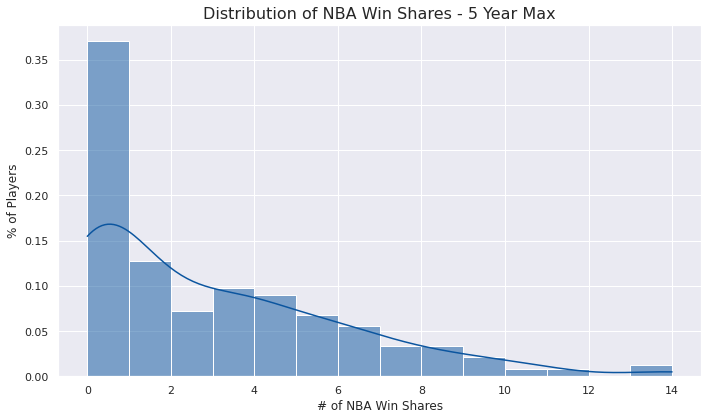

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=df, x="win_shares_nba", stat='probability', kde=True, bins=np.arange(0, 14.1, 1), color=blues[0])
ax.set_xlabel('# of NBA Win Shares')
ax.set_ylabel('% of Players')
ax.set_title('Distribution of NBA Win Shares - 5 Year Max', fontsize=16)
fig.tight_layout()

Nearly half the players have a 5-year NBA peak performance of less than 2 Win Shares. The number of players represented seems to decrease exponentially as Win Shares increase. This shows that only a small percentage of NCAA players drafted by the NBA have successful careers.

The top 50 players based on 5-year NBA peak performance are shown below. Nearly all the players who became All-Stars have more than 8 Win Shares, a level of performance that only 8% of the players were able to attain.

In [34]:
pd.concat([player, df.loc[:,['position_nba','win_shares_nba']]], axis=1).\
sort_values('win_shares_nba', ascending=False).reset_index(drop=True).head(50)

,player,position_nba,win_shares_nba
0,Anthony Davis,Big,14.0
1,Karl-Anthony Towns,Big,14.0
2,Kawhi Leonard,Wing,13.7
3,Jimmy Butler,Wing,11.2
4,Draymond Green,Wing,11.1
5,Damian Lillard,Guard,10.6
6,Kyrie Irving,Guard,10.4
7,Andre Drummond,Big,9.9
8,Kemba Walker,Guard,9.9
9,Isaiah Thomas,Guard,9.7


The following chart shows the 5-year peak performance distributions for each projected NBA position.

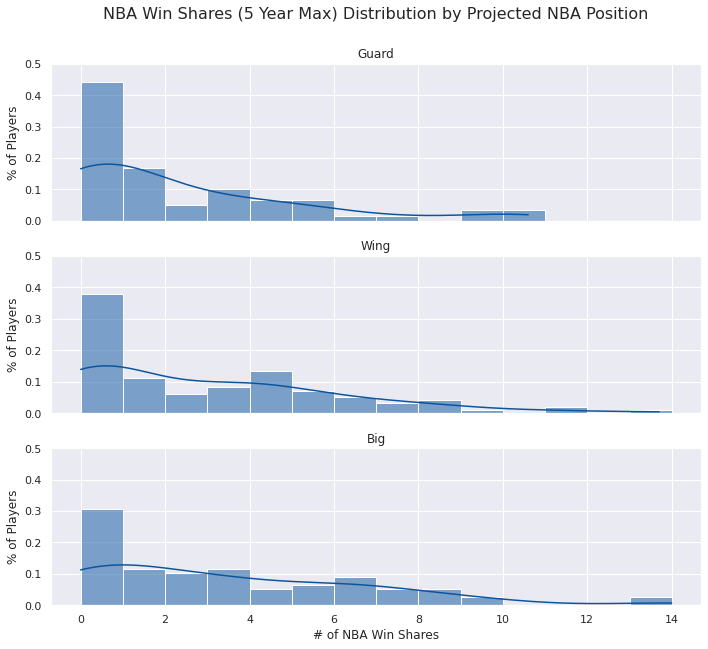

In [35]:
fig, axs = plt.subplots(nrows=3, figsize=(10, 9))

cats = ['Guard','Wing','Big']

for i, ax in enumerate(axs.ravel()):
    data = df[df.position_nba == cats[i]]
    sns.histplot(data=data, x="win_shares_nba", stat='probability', kde=True, bins=np.arange(0, 14.1, 1), ax=ax, color=blues[0])
    ax.set_title(cats[i])
    ax.set_xlim(-.7, 14.7)
    ax.set_ylim(0, .5)
    ax.set(xlabel='# of NBA Win Shares', ylabel='% of Players')
    ax.label_outer()
    
fig.suptitle('NBA Win Shares (5 Year Max) Distribution by Projected NBA Position', fontsize=16, x=.53, y=1)
fig.tight_layout()

The 5-year peak performance data of guards looks the least like that of the other positions. However, based on the p-value results of Kolmogorov-Smirnov tests, we cannot say with confidence that it comes from a different distribution than the others. Consequently, projected NBA position likely has little effect on 5-year peak performance.

In [36]:
ws_guard = df.loc[df.position_nba == 'Guard', 'win_shares_nba']
ws_wing = df.loc[df.position_nba == 'Wing', 'win_shares_nba']
ws_big = df.loc[df.position_nba == 'Big', 'win_shares_nba']

dist_list = [['Guard', ws_guard], ['Wing', ws_wing], ['Big', ws_big]]

for i in range(3):
    for j in range(i + 1, 3):
       print(dist_list[i][0], ' vs. ', dist_list[j][0], ': ', ks_2samp(dist_list[i][1], dist_list[j][1]), sep='')

Guard vs. Wing: KstestResult(statistic=0.1608439986163957, pvalue=0.26191204894868303)
Guard vs. Big: KstestResult(statistic=0.20034767492394612, pvalue=0.11386572075527435)
Wing vs. Big: KstestResult(statistic=0.09837781266352695, pvalue=0.7470057848155085)


<br>Here is the correlation matrix heatmap of the dataset. I first changed the categorical feature, position_nba, into dummy/indicator variables so that the correlations of its values would also show.

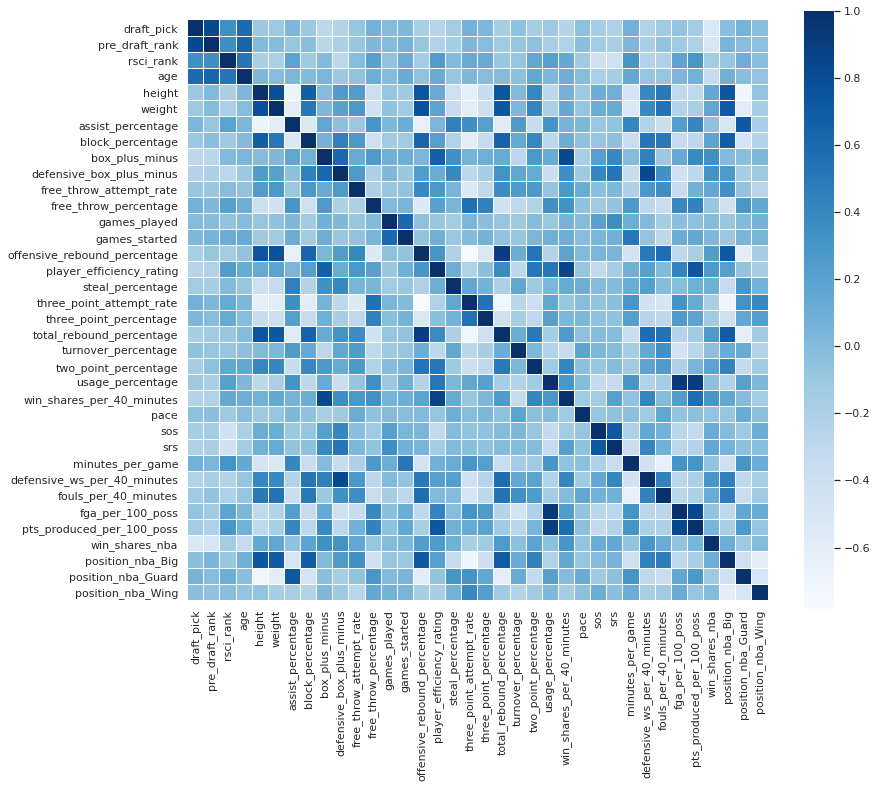

In [37]:
plt.figure(figsize=(13, 11))

corr = pd.get_dummies(df).corr()
ax = sns.heatmap(corr, xticklabels=True, yticklabels=True, linewidths=.004, square=True, cmap='Blues')

The features are now shown sorted in descending order based on the strength of their correlation with the target variable.

In [38]:
corr.win_shares_nba.sort_values(ascending=False, key=abs)[1:]

draft_pick                     -0.512643
pre_draft_rank                 -0.489129
age                            -0.336388
box_plus_minus                  0.333081
defensive_box_plus_minus        0.321380
win_shares_per_40_minutes       0.298121
defensive_ws_per_40_minutes     0.290742
player_efficiency_rating        0.267926
total_rebound_percentage        0.266764
offensive_rebound_percentage    0.242456
two_point_percentage            0.194891
block_percentage                0.194293
three_point_attempt_rate       -0.177785
weight                          0.173677
free_throw_attempt_rate         0.162781
srs                             0.154976
height                          0.152969
rsci_rank                      -0.137169
three_point_percentage         -0.129148
fouls_per_40_minutes            0.120480
sos                             0.117944
position_nba_Guard             -0.115592
position_nba_Big                0.105165
steal_percentage                0.089391
free_throw_perce

This shows that NBA Draft position, ESPN pre-draft ranking, age, Box Plus/Minus, and Defensive Box Plus/Minus have the strongest correlation with 5-year peak performance. It also confirms that projected NBA position has little correlation with the target variable.

The correlations of these features with the target variable are shown below in scatterplots.

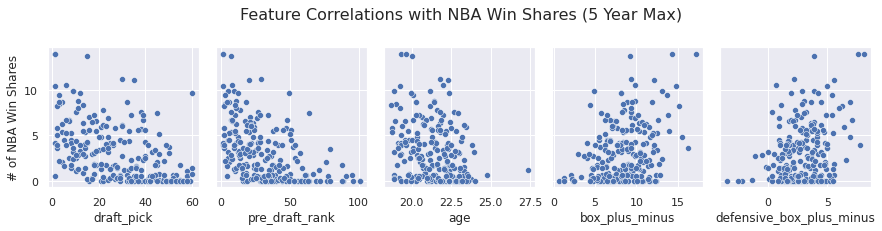

In [39]:
fig, axs = plt.subplots(ncols=5, figsize=(12.5, 3.2))

cols = ['draft_pick','pre_draft_rank','age','box_plus_minus','defensive_box_plus_minus']

for i, ax in enumerate(axs.ravel()):
    sns.scatterplot(x=cols[i], y='win_shares_nba', data=df, ax=ax)
    ax.set(ylabel='# of NBA Win Shares')
    ax.label_outer()
    
fig.suptitle('Feature Correlations with NBA Win Shares (5 Year Max)', fontsize=16, x=.53, y=1)
fig.tight_layout()

The plots show that draft position, pre-draft ranking, and age are negatively correlated with 5-year peak performance, while BPM and defensive BPM are positively correlated with the target variable.

The features with the strongest inter-feature correlations are now shown below.

In [40]:
cs = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
cs = cs.stack().sort_values(ascending=False)
cs[cs > .8]

usage_percentage              fga_per_100_poss               0.930851
usage_percentage              pts_produced_per_100_poss      0.913130
offensive_rebound_percentage  total_rebound_percentage       0.898053
player_efficiency_rating      win_shares_per_40_minutes      0.866715
box_plus_minus                win_shares_per_40_minutes      0.825948
defensive_box_plus_minus      defensive_ws_per_40_minutes    0.825058
draft_pick                    pre_draft_rank                 0.820958
fga_per_100_poss              pts_produced_per_100_poss      0.820459
dtype: float64

The strong positive correlations between these features all seem reasonable. Good rebounders are generally also good offensive rebounders, players are generally ranked close to their eventual draft position, and advanced performance statistics (i.e. WS/40, PER, and BPM) tend to rate players similarly.

Now I will create dummy variables for the lone categorical variable, position_nba. I will drop the first category/unique value of this feature, position_nba_Big, since only k - 1 indicator variables are needed to represent the k categories of a categorial variable.

In [8]:
# Convert feature into dummy variables
df = pd.get_dummies(df, columns=['position_nba'], drop_first=True)

The resulting dataset now has 34 dependent variables including 2 indicator variables.

The strong correlations shown previously between several of the features may indicate that there is still a significant amount of multicollinearity among the features of the dataset.

Multicollinearity is present when a feature in a multiple regression model can be linearly predicted from the other features with high accuracy. As I said previously, multicollinearity is problematic because it makes it difficult to determine the individual effects of features. High multicollinearity is particularly troublesome when it comes to ordinary least squares regression.

In the graph below, I show the amount of multicollinearity (as mearured by variance inflation factor) among the features as the number of features (ordered by strength of correlation with the target variable) varies.

In [42]:
# Filter dataset to only include features, ordered by strength of correlation with target
cols_corr = df.corr().win_shares_nba.abs().sort_values(ascending=False)[1:].index
df_corr = df.loc[:, cols_corr]

In [43]:
# Returns max VIF for each number of features via backward feature elimination
def VIF(data):
    result = {'features': [], 'vif': []}
    cols = data.shape[1]
    for i in range(cols):
        data = add_constant(data)
        max = 0
        for j in range(1, data.shape[1]):
            vif = variance_inflation_factor(data.values, j)
            if vif > max:
                max = vif
                imax = j
        result['vif'].append(max)
        result['features'].append(data.shape[1] - 1)
        data = data.iloc[:, 1:-1]
    return result

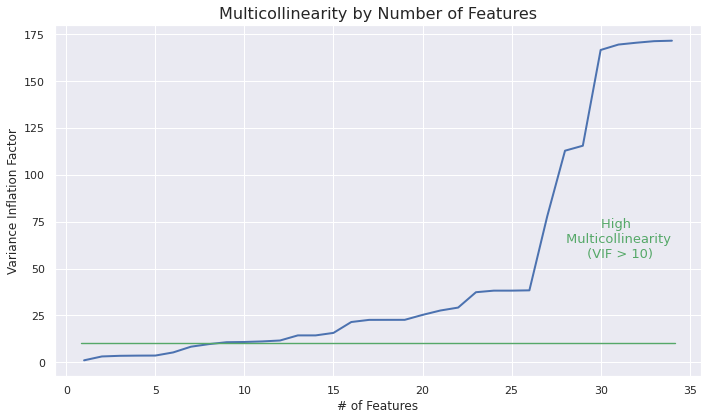

In [44]:
data = pd.DataFrame(VIF(df_corr))

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=data.features, y=data.vif, data=data, linewidth=2)
ax.axhline(10, .04, .96, color='g', linewidth=1.4)
ax.set_xlabel('# of Features')
ax.set_ylabel('Variance Inflation Factor')
ax.set_title('Multicollinearity by Number of Features', fontsize=16)
ax.text(31, 56, 'High \n Multicollinearity \n (VIF > 10)', transform=ax.transData, color='g', horizontalalignment='center',
       fontsize=13)
fig.tight_layout()

The multicollinearity of a dataset is generally considered high when the maximum VIF of the features is greater than 10. Based on this rule of thumb, the graph shows that multicollinearity becomes high approximately after the first 10 features (most correlated with the target variable) are included in the model. This information will guide some of my modeling decisions.
<br><br>

## Model Selection and Assessment

During the modeling process, I will assess the performance of 9 different optimized modeling algorithms. The best performing algorithm will then be used to create the final model. The following regression models will be utilized: elastic net, support vector, random forest, gradient boosting, and linear regression. I will also incorporate Pearson's rank based feature selection. For each model but linear regression, 2 modeling algorithms will be created: one with feature selection and one without. Due to high multicollinearity, linear regression will only be used with feature selection.

I have chosen to use nested cross-validation during the modeling process. Normally when modeling, the dataset is split into a train and test set, cross-validation is performed on the train set, and the performance of the best model is assessed on the test set. However, nested cross-validation allows you to perform both model selection and assessment without the need to set aside a test set. This is extremely useful when your dataset is small like mine (only 235 samples), since you want as many samples for training as possible.

With nested cross-validation, the cross-validation procedure for model selection is nested inside the cross-validation procedure for model assessment. Instead of one tuned model being selected, several are selected, each is assessed on a different part of the dataset, and the scores are averaged to give a performance score. Nested cross-validation assesses the performance of the optimal cross-validatory chosen model, the model obtained by applying the inner cross-validation procedure to the entire dataset.

Both repetition and stratification will be applied when performing nested cross-validation. Repetition is necessary for reliable model assessment due to the high variance of any single nested cross-validation run. Meanwhile, stratification increases the likelihood that each cross-validation fold is representative of the dataset as a whole.
<br><br>

The dataset is now divided into y, the target variable, and X which contains the predictor variables.

In [9]:
X = df.drop(columns='win_shares_nba')
y = df.win_shares_nba

Now I calculate the MSE of a very simple baseline model (the mean of the target variable) as a reference point for which to compare the results of the more advanced algorithms.

In [46]:
baseline_mse = np.mean(np.square(y - np.mean(y)))
print('Baseline MSE:', round(baseline_mse, 2))

Baseline MSE: 9.75


<br>
The following functions are used to bin the continuous target variable, stratify the repeated cross-validation folds based on the binned target variable, and perform nested cross-validation with repetition and stratification.

In [47]:
def stratify_cv(series, n_splits, n_repeats, random_state):
    cv = []
    rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

    for train_index, test_index in rskf.split(series, series):
        cv.append((train_index, test_index))
    return cv

In [48]:
def bin_series(series, bins):
    lst = [min(series), max(series) + 1]
    
    for i in range(1, bins):
        lst.insert(-1, series.quantile(i / bins))
    
    bin_arr = np.array(lst)
    indices = np.digitize(series, bin_arr)
    
    return pd.Series(indices).astype(str)

In [49]:
def nested_cv(X, y, model, param_grid):
    y_binned = bin_series(y, 5)
    cv_outer = stratify_cv(y_binned, n_splits=5, n_repeats=10, random_state=1)

    result = {'outer_score': [], 'inner_score': [], 'params': []}

    for train_index, test_index in cv_outer:
        X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        y_binned_train = y_binned.loc[train_index]
        cv_inner = stratify_cv(y_binned_train, n_splits=5, n_repeats=10, random_state=1)

        gs = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            cv=cv_inner
        )

        gs.fit(X_train, y_train)
        
        yhat = gs.best_estimator_.predict(X_test)
        mse = mean_squared_error(y_test, yhat)
        
        result['outer_score'].append(mse)
        result['inner_score'].append(-gs.best_score_)
        result['params'].append(gs.best_params_)
         
    return result

<br>
All of the modeling algorithms are defined below.

In [50]:
# Elastic net regression:

en = Pipeline([('scaler', StandardScaler()),
               ('model', ElasticNet())])

# Support vector regression:

sv = Pipeline([('scaler', StandardScaler()),
               ('model', SVR(kernel='rbf'))])

# Random forest regression:

rf = RandomForestRegressor(random_state=1)

# Gradient boosting regression:

gb = GradientBoostingRegressor(learning_rate=.1, random_state=1)

# Linear regression with feature selection:

lr_fs = Pipeline([('scaler', StandardScaler()),
                  ('selector', SelectKBest(score_func=f_regression)),
                  ('model', LinearRegression())])

# Elastic net regression with feature selection:

en_fs = Pipeline([('scaler', StandardScaler()),
                  ('selector', SelectKBest(score_func=f_regression)),
                  ('model', ElasticNet())])

# Support vector regression with feature selection:

sv_fs = Pipeline([('scaler', StandardScaler()),
                  ('selector', SelectKBest(score_func=f_regression)),
                  ('model', SVR(kernel='rbf'))])

# Random forest regression with feature selection:

rf_fs = Pipeline([('selector', SelectKBest(score_func=f_regression)),
                  ('model', RandomForestRegressor(random_state=1))])

# Random forest regression with feature selection:

gb_fs = Pipeline([('selector', SelectKBest(score_func=f_regression)),
                  ('model', GradientBoostingRegressor(learning_rate=.1, random_state=1))])

<br>
The hyperparameter grid of each algorithm is now defined. The grids were manually narrowed during the tuning process by observing the inner scores of repeated nested cross-validation.

In [51]:
# Elastic net regression:

grid_en = {
    'model__alpha': np.linspace(.1, 1, 10),
    'model__l1_ratio': np.linspace(.1, 1, 10)
}

# Support vector regression:

grid_sv = {
    'model__C': [1, 5, 10, 50, 100, 500, 1000, 5000, 10000],
    'model__gamma': [.0001, .0005, .001, .005, .01],
    'model__epsilon': [1, 2, 4],
}

# Random forest regression:

grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_features': [.2, .3, .4, .5, 1.0],
    'max_depth': [2, 3, 4, 5, 6]
}

# Gradient boosting regression:

grid_gb = {
    'n_estimators': [20, 25, 30, 35, 40, 45, 50],
    'max_depth': [1, 2, 3],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': [.7, .8, .9, 1.0]
}

# Linear regression with feature selection:

grid_lr_fs = {
    'selector__k': range(7, 12)
}

# Elastic net regression with feature selection:

grid_en_fs = {
    'selector__k': range(7, 12),
    'model__alpha': np.linspace(.1, 1, 10),
    'model__l1_ratio': np.linspace(.1, 1, 10)
}

# Support vector regression with feature selection:

grid_sv_fs = {
    'selector__k': range(7, 12),
    'model__C': [1, 5, 10, 50, 100, 500, 1000, 5000, 10000],
    'model__gamma': [.0001, .0005, .001, .005, .01],
    'model__epsilon': [1, 2, 4],
}

# Random forest regression with feature selection:

grid_rf_fs = {
    'selector__k': range(7, 12),
    'model__n_estimators': [100, 200, 300],
    'model__max_features': [.2, .3, .4, .5, 1.0],
    'model__max_depth': [2, 3, 4, 5, 6]
}

# Gradient boosting regression with feature selection:

grid_gb_fs = {
    'selector__k': range(7, 12),
    'model__n_estimators': [20, 25, 30, 35, 40, 45, 50],
    'model__max_depth': [1, 2, 3],
    'model__min_samples_leaf': [1, 2, 3, 4],
    'model__max_features': [.7, .8, .9, 1.0]
}

<br>
Repeated nested cross-validation is performed for each algorithm, and the results are saved in the dictionary, ncv_results.

I used Google Colab Pro to run the code below due to the significant computation time (several hours with a TPU) and saved the results in the file ncv_results.csv. In order to save time, I suggest that you skip ahead and import the file.

In [52]:
ncv_results = {}

In [53]:
# Elastic net regression:

ncv_en = nested_cv(X, y, en, grid_en)
ncv_results['en'] = ncv_en['outer_score']

In [54]:
# Support vector regression:

ncv_sv = nested_cv(X, y, sv, grid_sv)
ncv_results['sv'] = ncv_sv['outer_score']

In [55]:
# Random forest regression:

ncv_rf = nested_cv(X, y, rf, grid_rf)
ncv_results['rf'] = ncv_rf['outer_score']

In [56]:
# Gradient boosting regression:

ncv_gb = nested_cv(X, y, gb, grid_gb)
ncv_results['gb'] = ncv_gb['outer_score']

In [57]:
# Linear regression with feature selection:

ncv_lr_fs = nested_cv(X, y, lr_fs, grid_lr_fs)
ncv_results['lr_fs'] = ncv_lr_fs['outer_score']

In [58]:
# Elastic net regression with feature selection:

ncv_en_fs = nested_cv(X, y, en_fs, grid_en_fs)
ncv_results['en_fs'] = ncv_en_fs['outer_score']

In [59]:
# Support vector regression with feature selection:

ncv_sv_fs = nested_cv(X, y, sv_fs, grid_sv_fs)
ncv_results['sv_fs'] = ncv_sv_fs['outer_score']

In [60]:
# Random forest regression with feature selection:

ncv_rf_fs = nested_cv(X, y, rf_fs, grid_rf_fs)
ncv_results['rf_fs'] = ncv_rf_fs['outer_score']

In [61]:
# Gradient boosting regression with feature selection:

ncv_gb_fs = nested_cv(X, y, gb_fs, grid_gb_fs)
ncv_results['gb_fs'] = ncv_gb_fs['outer_score']

In [62]:
ncv_results = pd.DataFrame(ncv_results)

<br>
The nested cross-validation results from above are imported as a DataFrame.

In [10]:
ncv_results = pd.read_csv('ncv_results.csv')

<br>
The following chart shows the repeated nested cross-validation score distributions of each algorithm (with MSE as the scoring metric). The mean and quartiles of each distribution are displayed.

In [11]:
ncv_results.columns = ['Elastic Net','SVM','Random Forest','GBM','Linear Regression\n with FS','Elastic Net\n with FS',
                       'SVM\n with FS','Random Forest\n with FS','GBM\n with FS']

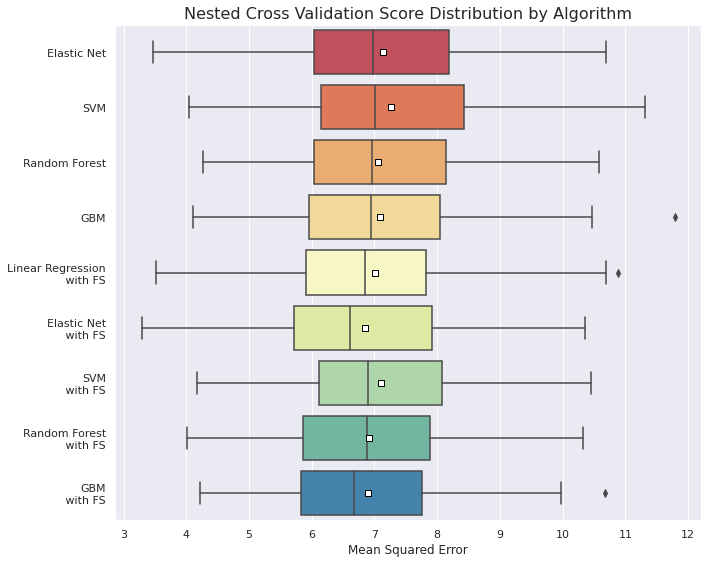

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=ncv_results, orient='h', palette='Spectral', showmeans=True,
            meanprops={'marker':'s', 'markerfacecolor':'white', 'markeredgecolor':'black'})
ax.set_xlabel('Mean Squared Error')
ax.set_title('Nested Cross Validation Score Distribution by Algorithm', fontsize=16)
ax.set_xticks(range(3, 13))
fig.tight_layout()

Each algorithm performs significantly better than the baseline model (9.75 MSE). Elastic net regression with Pearson's rank based feature selection has the lowest mean and median nested cross-validation score. Meanwhile, gradient boosting with feature selection, which performs slightly worse, has less score variance.

The results also show that Pearson's rank based feature selection improves the performance of every algorithm (linear regression was only performed with feature selection due to multicollinearity concerns).

The numerical results are all shown in the DataFrame below.

In [181]:
ncv = pd.melt(ncv_results, var_name='algorithm')
ncv = ncv.groupby('algorithm').value.agg(['mean', ('std', lambda x: np.std(x)), 'median']).round(2).sort_values('mean')
ncv.style.format('{:.2f}').set_properties(**{'text-align': 'center'}).\
set_table_styles([dict(selector='th', props=[('text-align', 'left')])]).set_table_attributes('style="font-size: 14px"')

,mean,std,median
algorithm,,,
Elastic Net with FS,6.84,1.47,6.62
GBM with FS,6.89,1.37,6.68
Random Forest with FS,6.91,1.37,6.87
Linear Regression with FS,7.01,1.56,6.85
Random Forest,7.05,1.38,6.96
GBM,7.09,1.44,6.94
SVM with FS,7.11,1.41,6.89
Elastic Net,7.14,1.48,6.97
SVM,7.27,1.55,7.01


<br>The following function is used to perform repeated cross-validation with stratification.

In [67]:
def cv(X, y, model, param_grid):
    y_binned = bin_series(y, 5)
    cv_inner = stratify_cv(y_binned, n_splits=5, n_repeats=10, random_state=1)
    
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        cv=cv_inner
    )

    gs.fit(X, y)
    
    return gs

<br>
To reiterate in more detail, nested cross-validation is the cross-validation assessment of large-sample performance of a model M chosen by a specific cross-validation protocol P. The cross-validation protocol is the procedure of selecting the optimal cross-validatory chosen model with pre-defined grid, number of folds and number of repeats.

For each algorithm, I will now find the hyperparameters of the model chosen by its cross-validation protocol. The inner loop of the nested cross-validation procedure is applied to the entire dataset, and the results are saved in the dictionary, cv_results.

In order to save time, I suggest you skip past the code below and import the file containing the pre-computed results, cv_results.csv.

In [68]:
cv_results = {}

alg_names = ncv.index.to_list()
algs = [en_fs, gb_fs, rf_fs, lr_fs, rf, gb, sv_fs, en, sv]
param_grids = [grid_en_fs, grid_gb_fs, grid_rf_fs, grid_lr_fs, grid_rf, grid_gb, grid_sv_fs, grid_en, grid_sv]

for name, alg, grid in zip(alg_names, algs, param_grids):
    cv_results[name] = [cv(X, y, alg, grid).best_params_]

<br>
The cross-validation results are imported as a DataFrame.

In [182]:
cv_results = pd.read_csv('cv_results.csv', index_col=0)

# Strings converted to dictionaries
for col in cv_results.columns:
    cv_results[col] = cv_results[col].apply(lambda x: ast.literal_eval(x))

<br>
The following DataFrame displays the hyperparameters of the optimal cross-validatory chosen model for each algorithm.

In [183]:
def edit_dict(x):
    x = {k: round(v, 1) if v > .01 else v for k, v in x.items()}
    if any('__' in k for k in x):
        return {k.split('__')[1]: v for k, v in x.items()}
    return x

In [184]:
cv_results = pd.DataFrame(cv_results).T

cv_results[0] = cv_results[0].apply(edit_dict)
cv_results.columns = ['parameters']
cv_results.index.name = 'algorithm'

with pd.option_context('display.max_colwidth', 200):
    display(cv_results.style.set_properties(**{'text-align': 'left'}).\
            set_table_styles([dict(selector='th', props=[('text-align', 'left')])]).\
            set_table_attributes('style="font-size: 14px"'))

,parameters
algorithm,
Elastic Net with FS,"{'alpha': 0.3, 'l1_ratio': 0.1, 'k': 9}"
GBM with FS,"{'max_depth': 2, 'max_features': 0.8, 'min_samples_leaf': 2, 'n_estimators': 25, 'k': 10}"
Random Forest with FS,"{'max_depth': 3, 'max_features': 0.3, 'n_estimators': 100, 'k': 10}"
Linear Regression with FS,{'k': 9}
Random Forest,"{'max_depth': 5, 'max_features': 0.4, 'n_estimators': 200}"
GBM,"{'max_depth': 2, 'max_features': 0.9, 'min_samples_leaf': 3, 'n_estimators': 30}"
SVM with FS,"{'C': 1000, 'epsilon': 2, 'gamma': 0.001, 'k': 9}"
Elastic Net,"{'alpha': 0.4, 'l1_ratio': 0.5}"
SVM,"{'C': 10, 'epsilon': 2, 'gamma': 0.005}"


<br>
For the best performing algorithm (elastic net regression with Pearson's rank based feature selection), I will now show how the optimal cross-validation score varies by number of features selected, k.

To accomplish this, I perform cross-validation with an expanded hyperparameter grid, where k takes on all values. As I previously stated, the hyperparameter grids were manually narrowed by checking the inner scores of nested cross-validation while tuning.

In order to save time, I suggest you skip past the code below and import the file containing the pre-computed results, cv_en_fs.csv.

In [72]:
grid_k_en_fs = {
    'selector__k': range(1, 35),
    'model__alpha': np.linspace(.1, 1, 10),
    'model__l1_ratio': np.linspace(.1, 1, 10)
}

cv_results_en_fs = cv(X, y, en_fs, grid_k_en_fs)

cv_en_fs = pd.DataFrame(cv_results_en_fs.cv_results_['params'])
cv_en_fs['mean_test_score'] = -cv_results_en_fs.cv_results_['mean_test_score']
cv_en_fs['std_test_score'] = cv_results_en_fs.cv_results_['std_test_score']

cv_en_fs = cv_en_fs.sort_values('mean_test_score').groupby('selector__k', as_index=False).first()

<br>
The cross-validation results from above are imported as a DataFrame.

In [73]:
cv_en_fs = pd.read_csv('cv_en_fs.csv', index_col=0)

<br>
The upper and lower bounds of the shaded area represent the standard deviation of the cross-validation scores of the optimal model for each value of k.

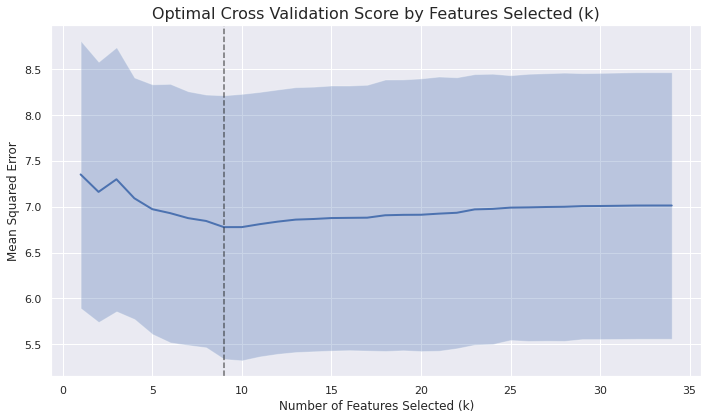

In [74]:
upper_bound = cv_en_fs.mean_test_score + cv_en_fs.std_test_score
lower_bound = cv_en_fs.mean_test_score - cv_en_fs.std_test_score

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=cv_en_fs, x='selector__k', y='mean_test_score', linewidth=2)
ax.fill_between(cv_en_fs.selector__k, upper_bound, lower_bound, alpha=.3)
ax.axvline(9, color='k', linestyle='--', alpha=.6)
ax.set_xlabel('Number of Features Selected (k)')
ax.set_ylabel('Mean Squared Error')
ax.set_title('Optimal Cross Validation Score by Features Selected (k)', fontsize=16)
fig.tight_layout()

This graphically shows that the value of the hyperparameter, k, of the optimal cross-validatory chosen model of elastic net regression with feature selection is indeed 9.
<br><br>

Now I will more closely analyze the repeated nested cross-validation results of elastic net regression with feature selection. 
The nested cross-validation results are imported as a DataFrame.

In [75]:
ncv_en_fs = pd.read_csv('ncv_en_fs.csv', index_col=0)

# Column of strings converted into dictionaries
ncv_en_fs['params'] = ncv_en_fs['params'].apply(lambda x: ast.literal_eval(x))

# Column of dictionaries converted into separate columns
ncv_en_fs = pd.DataFrame(ncv_en_fs, columns=['outer_score','inner_score']).join(pd.DataFrame(ncv_en_fs['params'].to_list()))

The average inner and outer scores of the repeated nested cross-validation are shown below.

The models are selected within the inner cross-validation, while they are assessed within the outer cross-validation of the procedure. The average inner score is slightly better than the average outer score. This is expected, since error estimation is somewhat positively biased when using cross-validation for model selection, whereas nested cross-validation gives an almost unbiased estimate of the true error. The small difference between the inner and outer scores indicates the unlikelihood of overfitting within the inner cross-validation, suggesting generalizability.

In [76]:
inner_score_en = round(ncv_en_fs.inner_score.mean(), 2)
outer_score_en = round(ncv_en_fs.outer_score.mean(), 2)
print('Inner CV Score:', inner_score_en)
print('Outer CV Score:', outer_score_en)

Inner CV Score: 6.79
Outer CV Score: 6.84


The following plots show the distribution of hyperparameters from the models selected within the inner cross-validation of the nested cross-validation procedure.

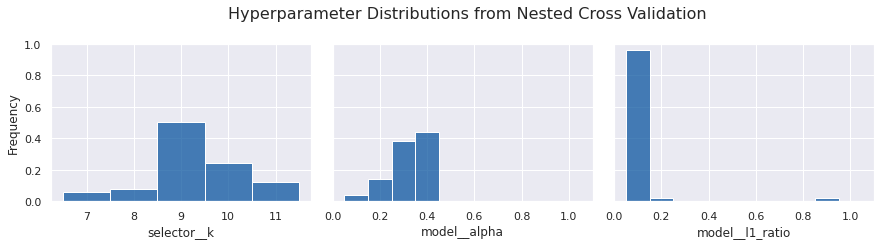

In [77]:
fig, axs = plt.subplots(ncols=3, figsize=(12.4, 3.5))

cols = ['selector__k','model__alpha','model__l1_ratio']
bins = [np.arange(6.5, 12, 1), np.arange(.05, 1.1, .1), np.arange(.05, 1.1, .1)]

for i, ax in enumerate(axs.ravel()):
    sns.histplot(data=ncv_en_fs, x=cols[i], stat='probability', bins=bins[i], ax=ax, color=blues[0])
    ax.set_ylim(0, 1)
    ax.set(ylabel='Frequency')
    ax.label_outer()
    
fig.suptitle('Hyperparameter Distributions from Nested Cross Validation', fontsize=16, x=.53, y=.97)
fig.tight_layout()

For each hyperparameter, there is one value present within at least 40% of the selected models. This shows that the optimal cross-validatory chosen model assessed via nested cross-validation is relatively stable, meaning that its predictions do not change much when the training data is slightly modified. This is good sign, since model stability is also associated with generalizability.

<br>
Elastic net and gradient boosting regression, each combined with Pearson's rank based feature selection, are the best performing algorithms based on the results of repeated nested cross-validation. Gradient boosting only slightly underperforms elastic net in terms of mean and median scores, doing so with less score variance. However, elastic net is a less complex model with far greater interpretability. Also, the nested cross-validation results of the elastic net model show that it likely did not overfit the training data, is relatively stable, and therefore likely generalizes well to new data.

For these reasons, I have chosen to use elastic net regression with Pearson's rank based feature selection to create my final model.

The full algorithm is shown below.

In [78]:
en_fs

Pipeline(steps=[('scaler', StandardScaler()),
                ('selector',
                 SelectKBest(score_func=<function f_regression at 0x7fe97f6e0050>)),
                ('model', ElasticNet())])

Now the hyperparameters of the optimal cross-validatory chosen model for elastic net regression with Pearson's rank based feature selection are displayed.

In [79]:
fm_params = cv_results.iloc[0,0]
fm_params

{'alpha': 0.3, 'l1_ratio': 0.1, 'k': 9}

The hyperparameters are added to the algorithm, and it is fit on the full dataset.

In [80]:
final_model = clone(en_fs)

final_model.set_params(selector__k=fm_params['k'], model__alpha=fm_params['alpha'], model__l1_ratio=fm_params['l1_ratio'])

final_model.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('selector',
                 SelectKBest(k=9,
                             score_func=<function f_regression at 0x7fe97f6e0050>)),
                ('model', ElasticNet(alpha=0.3, l1_ratio=0.1))])

With an L1 ratio of 0.1, the performance of the model is likley very similar to that of ridge regression (L1 ratio of zero).

The model works as follows: first the data is standardized, then 9 features are selected, and lastly the model multiplies each selected feature by a given coefficient and sums the results to make predictions.

The features and corresponding coefficients of the final model sorted by absolute value are displayed in the DataFrame below. Since the model standardizes the features, the impact of each feature on the prediction of the model is proportional to the absolute value of its coefficient.

In [185]:
mask = final_model.named_steps['selector'].get_support()
features_selected = X.loc[:, mask].columns.to_list()

coefs = final_model.named_steps['model'].coef_

coef_dict = {}
for f, c in zip(features_selected, coefs):
    coef_dict[f] = c
    
coef_dict = {'feature': features_selected, 'coefficient': coefs}
coef_df = pd.DataFrame(coef_dict).set_index('feature').sort_values('coefficient', ascending=False, key=abs)
coef_df.style.format('{:.2f}').set_properties(**{'text-align': 'center'}).\
set_table_styles([dict(selector='th', props=[('text-align', 'left')])]).set_table_attributes('style="font-size: 14px"')

,coefficient
feature,
draft_pick,-0.58
pre_draft_rank,-0.48
total_rebound_percentage,0.34
defensive_box_plus_minus,0.31
age,-0.29
box_plus_minus,0.22
win_shares_per_40_minutes,0.17
player_efficiency_rating,0.10
defensive_ws_per_40_minutes,0.00


The datset initially contained 35 features, but they were reduced to 9 for the model via feature selection. When the model is fitted on the full dataset, the coefficent of Defensive WS/40 is reduced to zero, effectively giving the final model only 8 features. Since correlation rank based feature selection is incorporated, the 8 features of the final model are those most correlated with 5-year peak performance.

According to my final model, the NBA Draft position of an NCAA player has the most influence on the player's 5-year NBA peak performance. Also, the 5 most important features of the model: draft position, pre-draft ranking, rebound percentage, Defensive BPM, and age, provide 80% of the influence for its predictions. It feels great to arrive at such a simple, interpretable final model after all this work!

## Next Steps

With a 2.62 RMSE performance and generalizability, I am very pleased with the results of my model, but it can certainly be improved. There are several avenues for improvement including: increasing the size of the dataset, adding more advanced features based on player tracking data, using more sophisticated feature selection methods such as sequential feature selection, and using Bayesian optimization for hyperparamter tuning. While these improvements may be complicated by data availability and computing power, I hope to implement them going forward. I may also consider using VORP or RAPTOR WAR instead of Win Shares to measure peak NBA performance in future modeling iterations, as they seem to more accurately value player contributions. In the end, this project has taught me that it is no small task to predict the performance of NBA prospects with a high level of accuracy, but I certainly won't stop trying!